<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/Gans_in_actiong/Ch2/Ch2_Autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 코드 2-1 기본 임포트
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.stats import norm
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 코드 2-2 하이퍼파라미너 설정하기
batch_size = 100
original_dim = 784 # Mnist 이미지의 높이 : 28, 너비 : 28 => 28*28
latent_dim = 2
intermediate_dim = 256
epochs = 50 # 에포크 횟수
epsilon_std = 1.0

In [3]:
# 코드 2-4 샘플링 함수 만들기
def sampling(args: tuple):
    # 튜플로 매개변수를 감쌉니다.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
# 코드 2-3 인코더 만들기
x = Input(shape=(original_dim,), name="input") # 인코더 입력
h = Dense(intermediate_dim, activation="relu", name="encoding")(x) # 중간층
z_mean = Dense(latent_dim, name="mean")(h) # 잠재 공간의 평균을 정의
z_log_var = Dense(latent_dim, name="log-varience")(h) # 잠재 공간의 로그 분산을 정의

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encodeer") # 케라스 모델로 인코더를 정의합니다.

In [5]:
encoder.summary()

Model: "encodeer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-varience (Dense)            (None, 2)            514         encoding[0][0]                   
___________________________________________________________________________________________

In [6]:
# 코드 2-5 디코더 만들기
input_decoder = Input(shape=(latent_dim,), name="decoder_input") # 디코더 입력
decoder_h = Dense(intermediate_dim, activation="relu",
                 name="decoder_h")(input_decoder) # 잠재공간을 중간층의 차원으로 변환한다. (256)
x_decoded = Dense(original_dim, activation="sigmoid",
                 name="flat_decoded")(decoder_h) # 원본 차원으로 변환한다.

decoder = Model(input_decoder, x_decoded, name="decoder") # 케라스 모델로 디코더를 정의

In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 코드 2-6 디코더 만들기
output_combined = decoder(encoder(x)[2]) # encoder 의 반환값 : [z_mean, z_log_var, z] 3번 째 값 이므로 z를 사용
vae = Model(x, output_combined) # 입력과 출력을 연결

In [9]:
vae.summary() # 모델구조 확인

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encodeer (Model)             [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 2-7 손실 함수를 정의

kl_loss = -0.5 * K.sum(
    1 + z_log_var - K.exp(z_log_var) - K.square(z_mean),
    axis=-1)

In [11]:
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy") # 모델 컴파일
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encodeer (Model)                [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          202256      encodeer[1][2]                   
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

In [12]:
# 코드 2-8 훈련/테스트 세트 분할하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [13]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
       batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2432
Epoch 2/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2167
Epoch 3/50
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2123
Epoch 4/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2097
Epoch 5/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2078
Epoch 6/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2063
Epoch 7/50
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2049
Epoch 8/50
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2036
Epoch 9/50
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2024
Epoch 10/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.2014
Epoch 11/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2005
Epoch 1

아래부터의 과정은 딥러닝과 관련있지 않은 내용이기 때문에 설명만 진행하도록 하겠습니다.

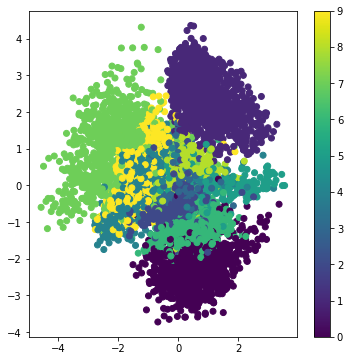

In [14]:
# 잠재 공간에 투영된 숫자 클래스의 2D 그래프
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.savefig('./Ch2/2Dgraph.jpg',dpi=400,bbox_inches='tight')
plt.show()

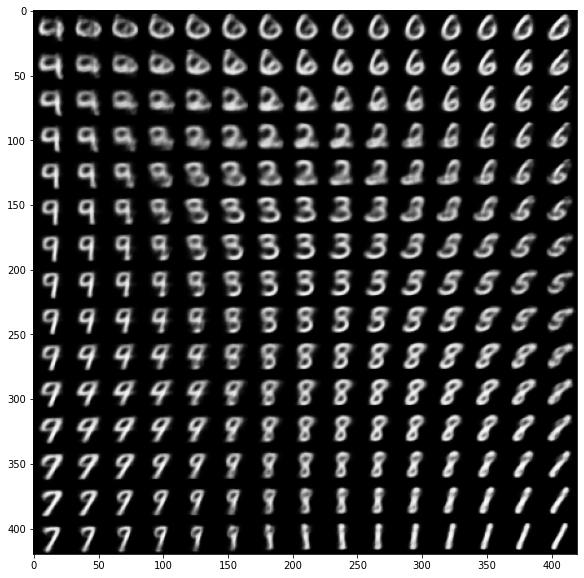

In [15]:
# 숫자의 2D 매니폴드 출력하기
n = 15  # 15x15 숫자를 담은 그림
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 잠재 공간을 가우스 분포로 가정했기 때문에 잠재 변수 z의 값을 만들기 위해
# 일정 간격으로 떨어진 좌표를 가우스 분포의 역 CDF(ppf)를 통해 변환합니다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('./Ch2/2D_Manifold.jpg',dpi=400,bbox_inches='tight')
plt.show()